# Weight Initialization

In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
num_workers = 0

batch_size = 100

valid_size = 0.2

transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(root = 'data', train = True, download = True,
                                  transform = transform)

test_data = datasets.FashionMNIST(root ='data', train=False, download=True, 
                                 transform = transform)

num_train = len(train_data)
indices = list(range(num_train))

np.random.shuffle(indices)

split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

#Data Loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler = train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler = valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,num_workers=num_workers)


# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Visualization of Some Training Data

(100, 1, 28, 28)


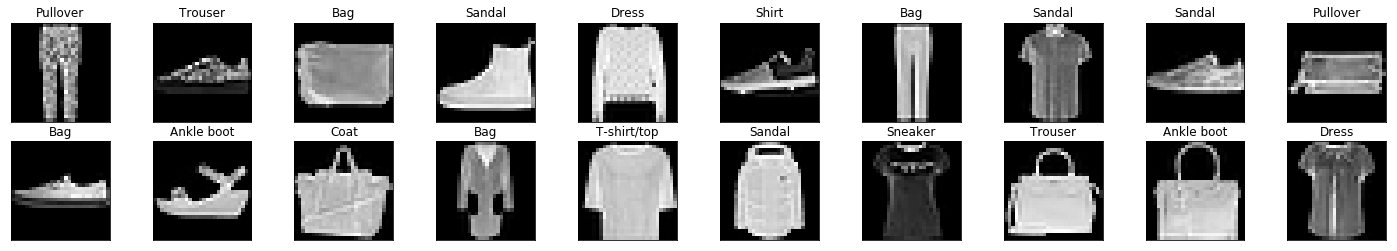

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(train_loader)
images, label = dataiter.next()

images = images.numpy()
print(images.shape)

fig = plt.figure(figsize = (25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks = [], yticks = [])
    ax.imshow(np.squeeze(images[idx]), cmap = 'gray')
    ax.set_title(classes[labels[idx]])

# Initialization Weights

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, hidden_1 = 256, hidden_2=128, constant_weight = None):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        self.dropout = nn.Dropout(0.2)
        
        
        if (constant_weight is not None):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.constant_(m.weight, constant_weight)
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

# Comparing the model behavior

In [15]:
model_0 = Net(constant_weight=0)
model_1 = Net(constant_weight=1)

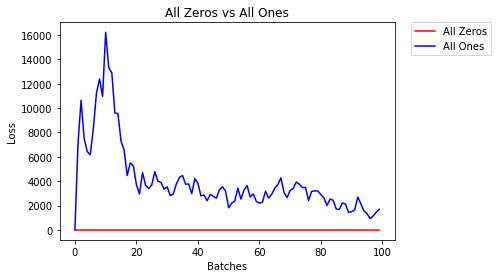

After 2 Epochs:
Validation Accuracy
    9.767% -- All Zeros
   10.017% -- All Ones
Training Loss
    2.304  -- All Zeros
  775.280  -- All Ones


In [17]:
import helpers

# put them in list form to compare
model_list = [(model_0, 'All Zeros'),
              (model_1, 'All Ones')]


# plot the loss over the first 100 batches
helpers.compare_init_weights(model_list, 
                             'All Zeros vs All Ones', 
                             train_loader,
                             valid_loader)

# Initializatiomn from Uniform Distribution

In [22]:
def weights_init_uniform(m):
    classname = m.__class__.__name__
    
    if classname.find('Linear') != -1:
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)
        

In [23]:
model = Net()
model.apply(weights_init_uniform)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

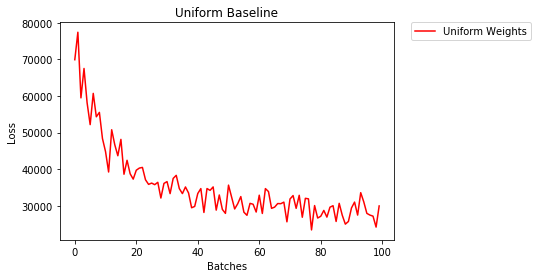

After 2 Epochs:
Validation Accuracy
   34.225% -- Uniform Weights
Training Loss
    5.541  -- Uniform Weights


In [26]:
helpers.compare_init_weights([(model, 'Uniform Weights')],
                            'Uniform Baseline',
                            train_loader,
                            valid_loader)

# General rule for weight initialization

The general fule for setting the weights in a NN s to set them to be close to zero without being too small

It is good practice to give range of [-y, y] where y = 1 / sqrt(n)

In [45]:
def weights_init_uniform_center(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.uniform_(-0.5, 0.5)
        m.bias.data.fill_(0)

In [46]:
model_centered = Net()
model_centered.apply(weights_init_uniform_center)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

We created above model for comparison purpose. Lets create another model with the general rule

In [47]:
def weights_init_uniform_general_rule(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        n = m.in_features
        y = 1.0 / np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [48]:
general_model = Net()
general_model.apply(weights_init_uniform_general_rule)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

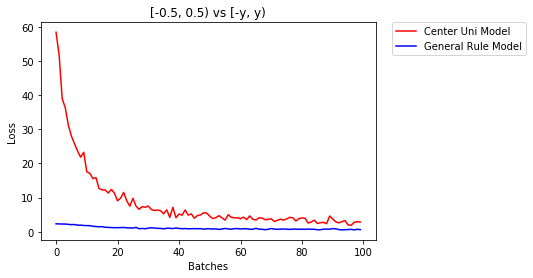

After 2 Epochs:
Validation Accuracy
   74.308% -- Center Uni Model
   85.517% -- General Rule Model
Training Loss
    0.956  -- Center Uni Model
    0.207  -- General Rule Model


In [49]:
import helpers

# put them in list form to compare
model_list = [(model_centered, 'Center Uni Model'),
              (general_model, 'General Rule Model')]


# plot the loss over the first 100 batches
helpers.compare_init_weights(model_list, 
                             '[-0.5, 0.5) vs [-y, y)', 
                             train_loader,
                             valid_loader)

Since the uniform distribution has the same chance to pick any value in a range, what if we used a distribution that had a higher chance of picking numbers closer to 0? Let's look at the normal distribution.

**Normal Distribution**
Unlike the uniform distribution, the normal distribution has a higher likelihood of picking number close to it's mean. To visualize it, let's plot values from NumPy's np.random.normal function to a histogram

> The normal distribution should have a mean of 0 and a standard deviation of $y=1/\sqrt{n}$

In [61]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        y = 1 / np.sqrt(m.in_features)
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)
        

In [62]:
uniform_model = Net()
uniform_model.apply(weights_init_normal)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

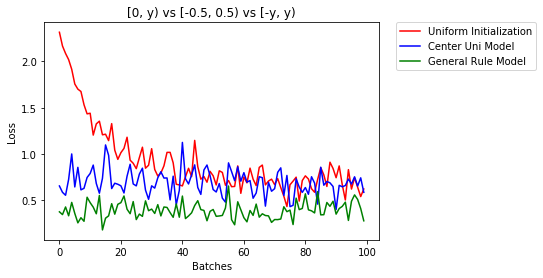

After 2 Epochs:
Validation Accuracy
   84.942% -- Uniform Initialization
   81.350% -- Center Uni Model
   86.592% -- General Rule Model
Training Loss
    0.250  -- Uniform Initialization
    0.506  -- Center Uni Model
    0.264  -- General Rule Model


In [63]:
import helpers

# put them in list form to compare
model_list = [ (uniform_model, 'Uniform Initialization'),
               (model_centered, 'Center Uni Model'),
               (general_model, 'General Rule Model')]


# plot the loss over the first 100 batches
helpers.compare_init_weights(model_list, 
                             '[0, y) vs [-0.5, 0.5) vs [-y, y)', 
                             train_loader,
                             valid_loader)

# Automatic Initialization

In [65]:
no_explicit_initialization = Net()

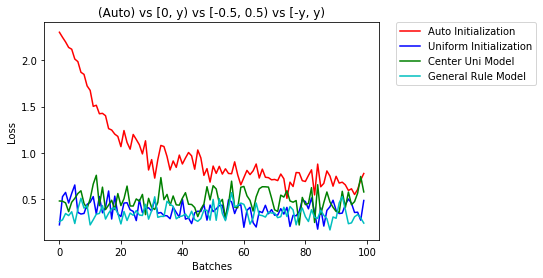

After 2 Epochs:
Validation Accuracy
   84.842% -- Auto Initialization
   85.542% -- Uniform Initialization
   83.258% -- Center Uni Model
   87.042% -- General Rule Model
Training Loss
    0.332  -- Auto Initialization
    0.314  -- Uniform Initialization
    0.343  -- Center Uni Model
    0.308  -- General Rule Model


In [66]:
import helpers

# put them in list form to compare
model_list = [ (no_explicit_initialization, 'Auto Initialization'),
                (uniform_model, 'Uniform Initialization'),
               (model_centered, 'Center Uni Model'),
               (general_model, 'General Rule Model')]


# plot the loss over the first 100 batches
helpers.compare_init_weights(model_list, 
                             '(Auto) vs [0, y) vs [-0.5, 0.5) vs [-y, y)', 
                             train_loader,
                             valid_loader)